# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. We start with the model.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

In [2]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

### Stacking a Deck

We need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [3]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for label in dset.targets:
        weights.append(label_weights[int(label)])
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [4]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [5]:
from torch.utils.data import DataLoader

batch_size = 64

# # create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

# This next cell applies only to the unstacked datasets, so you can get at the label counts the direct way (no list/zip) and you can use the datasets not the dataloaders (which is faster and simpler)

In [6]:
from collections import Counter

print("Test: ", Counter(int(y) for y in train_dset.targets).most_common())

print("Train:", Counter(int(y) for y in test_dset.targets).most_common())

Test:  [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]
Train: [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]


These plots show quickly that the sets are distributed fairly similarly.

# NOTE: you don't need plt.show in notebooks, that's a python script thing.

Note the semi-colon on the last line. That's a notebook trick to suppress printing the return value of the final statemnet (i.e. that weird `Patch` object that `ax.hist(...)` returns).

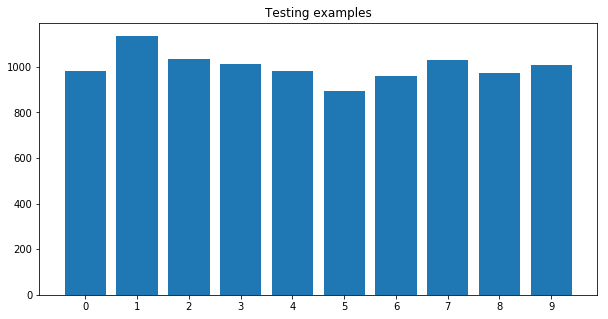

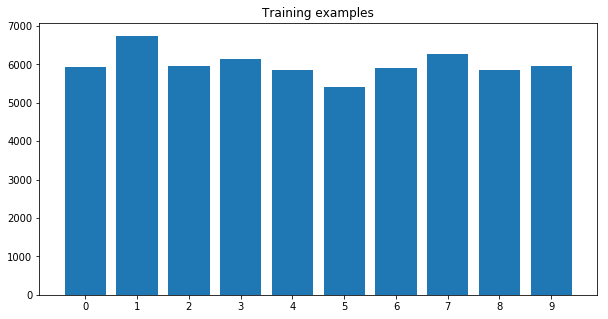

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Testing examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist(test_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Training examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist(train_dloader.dataset.targets, bins=range(11), histtype='bar', align='left', rwidth=0.8);

Here we do the sampling to create our skewed datasets.

In [8]:
from tqdm import tqdm

# create stacked loaders for the workers

skew_bias = 0.5
loader_size = 2048
num_workers = 2

stacked_data_loaders = []

for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


We should see the effect of the skew in a histogram of a skewed dataset.

# Here's the problem

The stacked_dataloader.target attributes, which should in principle just be all the labels in the dataset is for some reason not picking up on the stacking. It's just a copy of the `target` attribute of the original dataset. IMO that's a bug in pytorch. In any case, the consequence is, if you need all the labels in a dataset in one object, you can't just access the target attribute, you need to iterate through the list.

I don't _think_ the same bug exists in federated.py. It doesn't access `target` directly. It iterates (i.e. sees the stacked data). Although it might be judicious to check this.

# This is correct

This is the code you had before, just broken out to be clearer for you.

In [9]:
_, ybatches = list(zip(*stacked_data_loaders[1]))

# ybatches are like tensor([1,2,3,5,0,5], [1,2,3,0,1,8], ...), i.e. lots of batches.
# we need to join them together:

ys = torch.cat(ybatches)

# now we have tensor([1,2,3,5,0,5,1,2,3,0,1,8,...)

# and then we need to deal with the fact that Counter doesn't understand tensors
# i.e. turn ys into a list of integers, rather than a long tensor

ys = [int(y) for y in ys]

Counter(ys).most_common()

[(1, 408),
 (7, 237),
 (0, 193),
 (6, 190),
 (2, 190),
 (4, 186),
 (9, 174),
 (8, 166),
 (3, 166),
 (5, 138)]

# This is not

In [10]:
Counter(int(y) for y in stacked_data_loaders[1].dataset.targets).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

# So to make the plot

We made `ys` a couple of cells ago

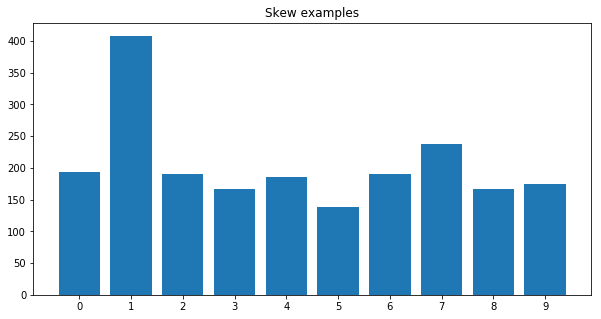

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Skew examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8);

In [12]:
import federated

learning_rate = 5e-3
num_epochs = 1
num_rounds = 5

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [13]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each\n" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

  0%|          | 0/5 [00:00<?, ?it/s]

Training 5 round(s) with 2 worker(s) doing 1 epoch(s) each

Beginning round 1
	Worker: 5672 	epoch: 1 	batch: 0 	local loss: 2.2960
	Worker: 5672 	epoch: 1 	batch: 8 	local loss: 2.3020
	Worker: 5672 	epoch: 1 	batch: 16 	local loss: 2.3067
	Worker: 5672 	epoch: 1 	batch: 24 	local loss: 2.2773
	Worker: 5672 	epoch: 1 	batch: 32 	local loss: 2.2735 

	Worker: 0264 	epoch: 1 	batch: 0 	local loss: 2.3023
	Worker: 0264 	epoch: 1 	batch: 8 	local loss: 2.2817
	Worker: 0264 	epoch: 1 	batch: 16 	local loss: 2.2605
	Worker: 0264 	epoch: 1 	batch: 24 	local loss: 2.2689
	Worker: 0264 	epoch: 1 	batch: 32 	local loss: 2.2816 



 20%|██        | 1/5 [00:11<00:47, 11.99s/it]

Finished round 1 with global loss: 2.28873 

Beginning round 2
	Worker: 5672 	epoch: 1 	batch: 0 	local loss: 2.2894
	Worker: 5672 	epoch: 1 	batch: 8 	local loss: 2.2677
	Worker: 5672 	epoch: 1 	batch: 16 	local loss: 2.2764
	Worker: 5672 	epoch: 1 	batch: 24 	local loss: 2.2452
	Worker: 5672 	epoch: 1 	batch: 32 	local loss: 2.2593 

	Worker: 0264 	epoch: 1 	batch: 0 	local loss: 2.2731
	Worker: 0264 	epoch: 1 	batch: 8 	local loss: 2.2660
	Worker: 0264 	epoch: 1 	batch: 16 	local loss: 2.2435
	Worker: 0264 	epoch: 1 	batch: 24 	local loss: 2.2462
	Worker: 0264 	epoch: 1 	batch: 32 	local loss: 2.2290 



 40%|████      | 2/5 [00:24<00:36, 12.00s/it]

Finished round 2 with global loss: 2.27714 

Beginning round 3
	Worker: 5672 	epoch: 1 	batch: 0 	local loss: 2.2663
	Worker: 5672 	epoch: 1 	batch: 8 	local loss: 2.2623
	Worker: 5672 	epoch: 1 	batch: 16 	local loss: 2.2526
	Worker: 5672 	epoch: 1 	batch: 24 	local loss: 2.2522
	Worker: 5672 	epoch: 1 	batch: 32 	local loss: 2.2475 

	Worker: 0264 	epoch: 1 	batch: 0 	local loss: 2.2489
	Worker: 0264 	epoch: 1 	batch: 8 	local loss: 2.2455
	Worker: 0264 	epoch: 1 	batch: 16 	local loss: 2.2416
	Worker: 0264 	epoch: 1 	batch: 24 	local loss: 2.2045
	Worker: 0264 	epoch: 1 	batch: 32 	local loss: 2.2224 



 60%|██████    | 3/5 [00:37<00:24, 12.37s/it]

Finished round 3 with global loss: 2.26558 

Beginning round 4
	Worker: 5672 	epoch: 1 	batch: 0 	local loss: 2.2689
	Worker: 5672 	epoch: 1 	batch: 8 	local loss: 2.2480
	Worker: 5672 	epoch: 1 	batch: 16 	local loss: 2.2630
	Worker: 5672 	epoch: 1 	batch: 24 	local loss: 2.2344
	Worker: 5672 	epoch: 1 	batch: 32 	local loss: 2.2647 

	Worker: 0264 	epoch: 1 	batch: 0 	local loss: 2.2189
	Worker: 0264 	epoch: 1 	batch: 8 	local loss: 2.2263
	Worker: 0264 	epoch: 1 	batch: 16 	local loss: 2.2405
	Worker: 0264 	epoch: 1 	batch: 24 	local loss: 2.2063
	Worker: 0264 	epoch: 1 	batch: 32 	local loss: 2.2005 



 80%|████████  | 4/5 [00:50<00:12, 12.64s/it]

Finished round 4 with global loss: 2.25385 

Beginning round 5
	Worker: 5672 	epoch: 1 	batch: 0 	local loss: 2.2550
	Worker: 5672 	epoch: 1 	batch: 8 	local loss: 2.2205
	Worker: 5672 	epoch: 1 	batch: 16 	local loss: 2.2358
	Worker: 5672 	epoch: 1 	batch: 24 	local loss: 2.2217
	Worker: 5672 	epoch: 1 	batch: 32 	local loss: 2.2614 

	Worker: 0264 	epoch: 1 	batch: 0 	local loss: 2.2038
	Worker: 0264 	epoch: 1 	batch: 8 	local loss: 2.2050
	Worker: 0264 	epoch: 1 	batch: 16 	local loss: 2.2007
	Worker: 0264 	epoch: 1 	batch: 24 	local loss: 2.1793
	Worker: 0264 	epoch: 1 	batch: 32 	local loss: 2.0983 



100%|██████████| 5/5 [01:02<00:00, 12.57s/it]

Finished round 5 with global loss: 2.24125 



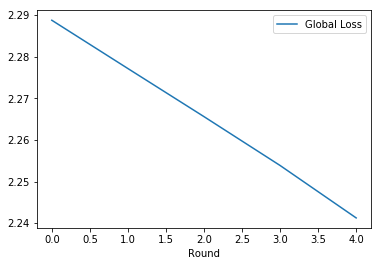

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss")
ax.set_xlabel("Round");
ax.legend();

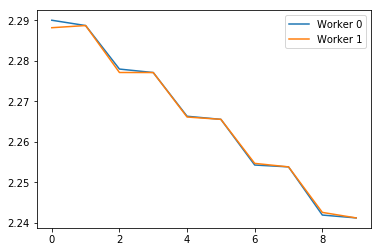

In [15]:
fig, ax = plt.subplots()

for i in range(len(manager.worker_loss_histories)):
    lbl = "Worker " + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- why use ten workers? Why not fewer?